In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# paths (workspace)
sales_path = "/workspaces/TeamCPH/data/umsatzdaten_gekuerzt.csv"
wetter_path = "/workspaces/TeamCPH/data/wetter1.csv"
kiwo_path = "/workspaces/TeamCPH/data/kiwo.csv"
holidays_path = "/workspaces/TeamCPH/data/school_holidays_SH.csv"
test_path = "/workspaces/TeamCPH/data/test.csv"

# -----------------------------
# 1) LOAD SALES (KEEP Warengruppe) + AGGREGATE TO DAILY PER GROUP
# -----------------------------
sales = pd.read_csv(sales_path, parse_dates=["Datum"])

sales_daily = (
    sales
    .groupby(["Datum", "Warengruppe"], as_index=False)["Umsatz"]
    .sum()
)

# -----------------------------
# MAPE STABILITY STATS (from TRAINING only)
# -----------------------------
# group-specific lower bound (5th percentile of raw sales rows)
min_by_wg = (
    sales.groupby("Warengruppe")["Umsatz"]
    .quantile(0.05)
    .to_dict()
)

# group mean of DAILY totals (better anchor for smoothing)
train_daily = (
    sales.groupby(["Datum", "Warengruppe"], as_index=False)["Umsatz"]
    .sum()
)
wg_means = train_daily.groupby("Warengruppe")["Umsatz"].mean().to_dict()

# -----------------------------
# 2) LOAD EXOGENOUS DATA (date-level)
# -----------------------------
wetter = pd.read_csv(wetter_path, parse_dates=["Datum"])
kiwo = pd.read_csv(kiwo_path, parse_dates=["Datum"])
holidays = pd.read_csv(holidays_path, parse_dates=["Datum"])
test = pd.read_csv(test_path, parse_dates=["Datum"])  # used later for prediction panel

# -----------------------------
# 3) MERGE (date-level onto panel)
# IMPORTANT: Do NOT merge test into training as rows; only merge date-level columns if needed.
# Here, we don't need test in training at all.
# -----------------------------
merged = sales_daily.merge(wetter, on="Datum", how="left")
merged = merged.merge(kiwo, on="Datum", how="left")
merged = merged.merge(holidays, on="Datum", how="left")

# -----------------------------
# 4) CLEANUP + SORT
# -----------------------------
if "KielerWoche" in merged.columns:
    merged["KielerWoche"] = merged["KielerWoche"].fillna(0).astype(int)
else:
    merged["KielerWoche"] = 0

merged = merged.sort_values(["Warengruppe", "Datum"]).reset_index(drop=True)

# -----------------------------
# 5) CALENDAR FEATURES
# -----------------------------
merged["IsWeekend"] = merged["Datum"].dt.weekday.isin([5, 6]).astype(int)
merged["IsNewYears"] = (merged["Datum"].dt.strftime("%m-%d") == "12-31").astype(int)

halloween_days = [f"10-{day:02d}" for day in range(24, 32)]
merged["IsHalloween"] = merged["Datum"].dt.strftime("%m-%d").isin(halloween_days).astype(int)

# -----------------------------
# 6) SEASONALITY (Fourier)
# -----------------------------
merged["DayOfYear"] = merged["Datum"].dt.dayofyear
merged["sin_1y"] = np.sin(2 * np.pi * merged["DayOfYear"] / 365.25)
merged["cos_1y"] = np.cos(2 * np.pi * merged["DayOfYear"] / 365.25)
merged["sin_2y"] = np.sin(4 * np.pi * merged["DayOfYear"] / 365.25)
merged["cos_2y"] = np.cos(4 * np.pi * merged["DayOfYear"] / 365.25)

# -----------------------------
# 7) TIME STRUCTURE (lags WITHIN Warengruppe)
# -----------------------------
merged["Revenue_lag1"] = merged.groupby("Warengruppe")["Umsatz"].shift(1)
merged["Revenue_lag7"] = merged.groupby("Warengruppe")["Umsatz"].shift(7)

# -----------------------------
# 8) ITEM GROUP FIXED EFFECTS (Warengruppe dummies)
# IMPORTANT: dtype=int avoids bool issues in statsmodels.
# -----------------------------
wg_dummies_train = pd.get_dummies(merged["Warengruppe"], prefix="WG", drop_first=True, dtype=int)
merged = pd.concat([merged, wg_dummies_train], axis=1)

# -----------------------------
# 9) FIT POOLED OLS ON log1p(Umsatz) (MAPE-friendly)
# -----------------------------
# If your holidays file uses different column names, adjust here
# (These are based on what you used earlier)
for col in ["holiday", "Easter"]:
    if col not in merged.columns:
        merged[col] = 0

predictors = [
    "holiday", "IsWeekend", "IsNewYears", "Easter",
    "KielerWoche",
    "sin_1y", "cos_1y", "sin_2y",
    "Revenue_lag1", "Revenue_lag7",
] + wg_dummies_train.columns.tolist()

model_df = merged[["Umsatz", "Warengruppe"] + predictors].replace([np.inf, -np.inf], np.nan).dropna()

model_df["log_Umsatz"] = np.log1p(model_df["Umsatz"])

Y = model_df["log_Umsatz"]
X = sm.add_constant(model_df[predictors])

results = sm.OLS(Y, X).fit(
    cov_type="HAC",
    cov_kwds={"maxlags": 7}
)

# -----------------------------
# WARRENGRUPPE-SPECIFIC BIAS CORRECTION (TRAINING)
# -----------------------------
train_pred_log = results.predict(X)
train_pred = np.expm1(train_pred_log)
train_true = model_df["Umsatz"]

bias_by_wg = (
    train_true / np.maximum(train_pred, 1e-6)
).groupby(model_df["Warengruppe"]).median()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             log_Umsatz   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1969.
Date:                Thu, 18 Dec 2025   Prob (F-statistic):               0.00
Time:                        19:12:04   Log-Likelihood:                -1094.8
No. Observations:                9292   AIC:                             2222.
Df Residuals:                    9276   BIC:                             2336.
Df Model:                          15                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.4534      0.015    297.668   

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# -----------------------------
# 0) Load test + sample_submission
# -----------------------------
test = pd.read_csv(test_path, parse_dates=["Datum"])
sub = pd.read_csv("/workspaces/TeamCPH/data/sample_submission.csv")

# -----------------------------
# 1) Build test PANEL: (Datum x Warengruppe)
# -----------------------------
if "Warengruppe" in test.columns:
    test_panel = test[["id", "Datum", "Warengruppe"]].copy()
else:
    warengruppen = sales["Warengruppe"].dropna().unique()
    dates = test[["id", "Datum"]].drop_duplicates()

    test_panel = dates.assign(_key=1).merge(
        pd.DataFrame({"Warengruppe": warengruppen, "_key": 1}),
        on="_key",
        how="outer"
    ).drop(columns="_key")

# -----------------------------
# 2) Merge date-level exogenous features onto test panel
# -----------------------------
test_feat = test_panel.merge(wetter, on="Datum", how="left")
test_feat = test_feat.merge(kiwo, on="Datum", how="left")
test_feat = test_feat.merge(holidays, on="Datum", how="left")

# Ensure required columns exist
for col in ["holiday", "Easter"]:
    if col not in test_feat.columns:
        test_feat[col] = 0

if "KielerWoche" in test_feat.columns:
    test_feat["KielerWoche"] = test_feat["KielerWoche"].fillna(0).astype(int)
else:
    test_feat["KielerWoche"] = 0

# -----------------------------
# 3) Calendar features
# -----------------------------
test_feat["IsWeekend"] = test_feat["Datum"].dt.weekday.isin([5, 6]).astype(int)
test_feat["IsNewYears"] = (test_feat["Datum"].dt.strftime("%m-%d") == "12-31").astype(int)


# -----------------------------
# 4) Seasonality features (Fourier)
# -----------------------------
test_feat["DayOfYear"] = test_feat["Datum"].dt.dayofyear
test_feat["sin_1y"] = np.sin(2 * np.pi * test_feat["DayOfYear"] / 365.25)
test_feat["cos_1y"] = np.cos(2 * np.pi * test_feat["DayOfYear"] / 365.25)
test_feat["sin_2y"] = np.sin(4 * np.pi * test_feat["DayOfYear"] / 365.25)

# -----------------------------
# 5) Warengruppe dummies matching training model columns
# -----------------------------
model_cols = results.model.exog_names  # includes 'const'
needed_cols = [c for c in model_cols if c != "const"]

wg_dummies_test = pd.get_dummies(test_feat["Warengruppe"], prefix="WG", drop_first=True, dtype=int)
test_feat = pd.concat([test_feat, wg_dummies_test], axis=1)

# Add any missing dummy columns expected by the model
for c in needed_cols:
    if c.startswith("WG_") and c not in test_feat.columns:
        test_feat[c] = 0

# -----------------------------
# 6) Build history for recursive lags from TRAIN actual daily totals
# -----------------------------
train_hist = (
    sales
    .groupby(["Datum", "Warengruppe"], as_index=False)["Umsatz"]
    .sum()
    .sort_values(["Warengruppe", "Datum"])
)

history = train_hist.rename(columns={"Umsatz": "Umsatz_known"}).copy()

# -----------------------------
# 7) Recursive prediction with correct log->revenue conversion + MAPE stabilizers
# -----------------------------
test_feat = test_feat.sort_values(["Warengruppe", "Datum"]).reset_index(drop=True)

alpha = 0.8  # smoothing strength: higher trusts model more
preds = []

for wg, grp in test_feat.groupby("Warengruppe", sort=False):
    grp = grp.sort_values("Datum").copy()

    for i, row in grp.iterrows():
        d = row["Datum"]

        # lags from history
        lag1 = history.loc[
            (history["Warengruppe"] == wg) & (history["Datum"] == d - pd.Timedelta(days=1)),
            "Umsatz_known"
        ]
        lag7 = history.loc[
            (history["Warengruppe"] == wg) & (history["Datum"] == d - pd.Timedelta(days=7)),
            "Umsatz_known"
        ]

        rev_lag1 = float(lag1.iloc[0]) if len(lag1) else np.nan
        rev_lag7 = float(lag7.iloc[0]) if len(lag7) else np.nan

        # Build xrow with exact columns the model expects
        xrow = {col: row.get(col, 0.0) for col in needed_cols}
        xrow["Revenue_lag1"] = 0.0 if pd.isna(rev_lag1) else rev_lag1
        xrow["Revenue_lag7"] = 0.0 if pd.isna(rev_lag7) else rev_lag7

        X_row = pd.DataFrame([xrow]).apply(pd.to_numeric, errors="coerce").fillna(0)
        X_row = sm.add_constant(X_row, has_constant="add")

        # ---- PREDICT (log space -> revenue space) ----
        yhat_log = float(results.predict(X_row).iloc[0])
        yhat = np.expm1(yhat_log)  # <-- CRITICAL FIX

        # ---- MAPE stabilizers (correct place) ----
        floor = min_by_wg.get(wg, 1.0)
        mean_val = wg_means.get(wg, floor)

        # adaptive floor: tighter for low-volume groups
        adaptive_floor = max(1.0, min(0.3 * mean_val, floor))

        yhat = max(yhat, adaptive_floor)
        yhat = alpha * yhat + (1 - alpha) * wg_means.get(wg, yhat)  # shrink to group mean
        yhat *= bias_by_wg.get(wg, 1.0)
        yhat = max(yhat, 0.0)  # no negative revenue

        preds.append({"id": row["id"], "Umsatz_pred": yhat})

        # update history with FINAL revenue prediction (so recursive lags are consistent)
        history = pd.concat(
            [history, pd.DataFrame([{"Datum": d, "Warengruppe": wg, "Umsatz_known": yhat}])],
            ignore_index=True
        )

pred_df = pd.DataFrame(preds)

# -----------------------------
# 8) Map to submission format (id + Umsatz)
# -----------------------------
out = sub[["id"]].merge(pred_df.groupby("id", as_index=False)["Umsatz_pred"].sum(), on="id", how="left")
out = out.rename(columns={"Umsatz_pred": "Umsatz"})

# safety: fill any missing predictions (shouldn't happen)
out["Umsatz"] = out["Umsatz"].fillna(out["Umsatz"].median()).clip(lower=0)

# -----------------------------
# 9) Save submission
# -----------------------------
out.to_csv("/workspaces/TeamCPH/submission.csv", index=False)
print(out.head())
print("Saved to /workspaces/TeamCPH/submission.csv")


        id      Umsatz
0  1808011  131.171376
1  1808021  141.204686
2  1808031  141.625164
3  1808041  158.983940
4  1808051  147.808997
Saved to /workspaces/TeamCPH/submission.csv


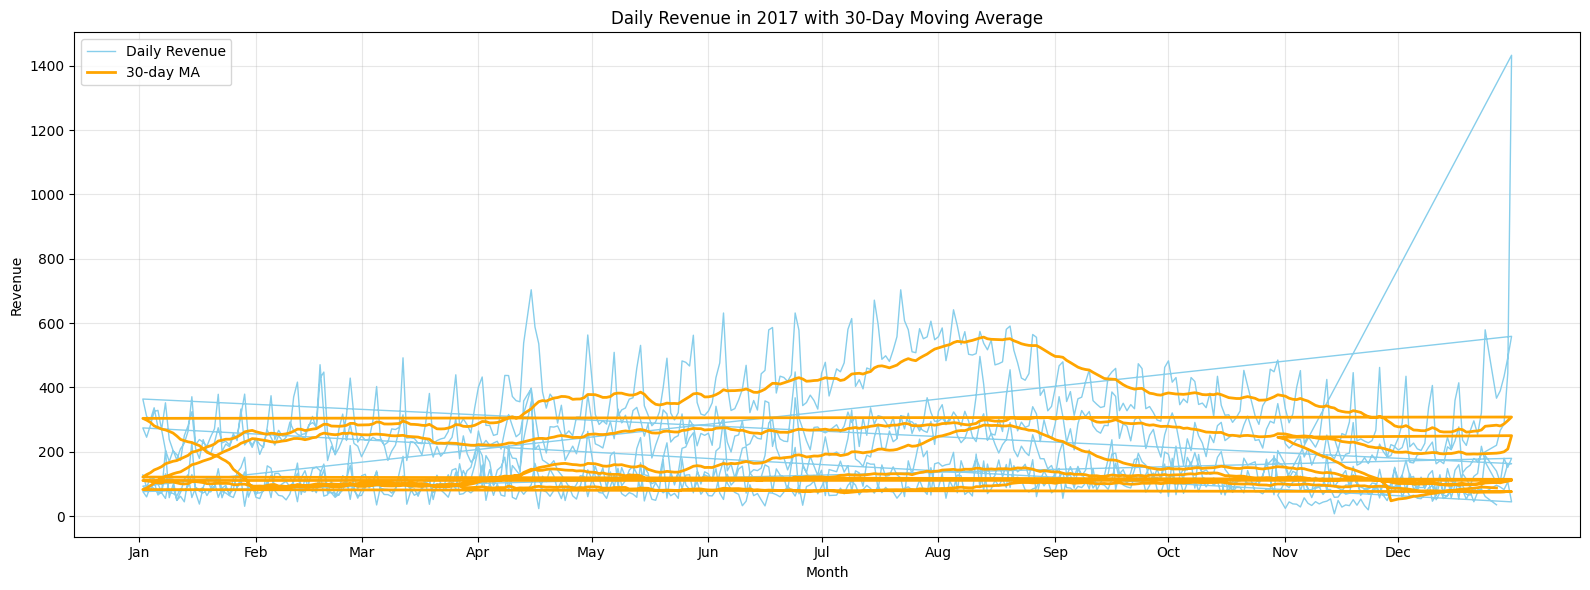

In [11]:
import matplotlib.pyplot as plt
import pandas as pd


# Filter for 2018 only
df_2017 = merged[merged["Datum"].dt.year == 2017].copy()

# Calculate 30-day moving average
df_2017["MA30"] = df_2017["Umsatz"].rolling(window=30).mean()

# Plot
plt.figure(figsize=(16, 6))

plt.plot(df_2017["Datum"], df_2017["Umsatz"], 
         label="Daily Revenue", color="skyblue", linewidth=1)

plt.plot(df_2017["Datum"], df_2017["MA30"], 
         label="30-day MA", color="orange", linewidth=2)

# Set title and labels
plt.title("Daily Revenue in 2017 with 30-Day Moving Average")
plt.xlabel("Month")
plt.ylabel("Revenue")

# Format x-axis to show months
plt.xticks(
    ticks=pd.date_range(start="2017-01-01", end="2017-12-31", freq="MS"),
    labels=[d.strftime("%b") for d in pd.date_range("2017-01-01", "2017-12-31", freq="MS")]
)

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
# descriptive statistics
import numpy as np

# basic shape and info
print('Shape:', merged.shape)

# basic descriptive statistics for key variables
stats = merged[['Revenue', 'CloudCover','Temperature','WindSpeed']].describe()
print('Descriptive statistics for key variables:')
print(stats)

Shape: (9334, 27)
Descriptive statistics for key variables:
           Revenue   CloudCover  Temperature    WindSpeed
count  9334.000000  9264.000000  9318.000000  9318.000000
mean    206.749044     4.720747    12.028483    10.974780
std     144.545189     2.646273     7.232829     4.131974
min       7.051201     0.000000    -8.475000     3.000000
25%      96.897441     3.000000     6.237500     8.000000
50%     161.900831     6.000000    11.625000    10.000000
75%     280.644663     7.000000    17.962500    13.000000
max    1879.461831     8.000000    31.437500    35.000000


In [14]:
# cleaning the dataset 

# analyse the 'Not a Number' (NaN) values in each column
# the intention is to remove from the dataset rows containing NaN values
nan_per_column = merged.isnull().sum()
print('NaN values in each column:')
print(nan_per_column)

# Clean NaN values only for rows before positional index 1819 (iloc)
cutoff_pos = 1819
n_rows = len(merged)

if cutoff_pos <= 0:
    # nothing to clean before 0
    merged_cleaned = merged.copy()
elif cutoff_pos >= n_rows:
    # cutoff beyond end -> clean whole dataframe
    merged_cleaned = merged.dropna(subset=['CloudCover', 'Temperature', 'WindSpeed'], how='any')
else:
    # split by positional index: pre (0..cutoff_pos-1) and post (cutoff_pos..end)
    pre = merged.iloc[:cutoff_pos].dropna(subset=['CloudCover', 'Temperature', 'WindSpeed'], how='any')
    post = merged.iloc[cutoff_pos:]
    # concat preserving original indices and order
    merged_cleaned = pd.concat([pre, post]).sort_index()

print('Original shape:', merged.shape)
print('Shape after selective cleaning:', merged_cleaned.shape)
print(merged_cleaned.head())

NaN values in each column:
Date                  0
Warengruppe           0
Revenue               0
CloudCover           70
Temperature          16
WindSpeed            16
WeatherCode        2325
WeatherCategory      16
KielWeek              0
holiday               0
Easter                0
id                 9334
IsWeekend             0
IsNewYears            0
IsHalloween           0
DayOfYear             0
sin_1y                0
cos_1y                0
sin_2y                0
cos_2y                0
Revenue_lag1          6
Revenue_lag7         42
WG_2                  0
WG_3                  0
WG_4                  0
WG_5                  0
WG_6                  0
dtype: int64
Original shape: (9334, 27)
Shape after selective cleaning: (9322, 27)
        Date  Warengruppe     Revenue  CloudCover  Temperature  WindSpeed  \
0 2013-07-01            1  148.828353         6.0      17.8375       15.0   
1 2013-07-02            1  159.793757         3.0      17.3125       10.0   
2 2013-07-0

In [15]:
nan_per_column = merged_cleaned.isnull().sum()
print('NaN values in each column:')
print(nan_per_column)

NaN values in each column:
Date                  0
Warengruppe           0
Revenue               0
CloudCover           58
Temperature          13
WindSpeed            13
WeatherCode        2313
WeatherCategory      13
KielWeek              0
holiday               0
Easter                0
id                 9322
IsWeekend             0
IsNewYears            0
IsHalloween           0
DayOfYear             0
sin_1y                0
cos_1y                0
sin_2y                0
cos_2y                0
Revenue_lag1          6
Revenue_lag7         42
WG_2                  0
WG_3                  0
WG_4                  0
WG_5                  0
WG_6                  0
dtype: int64


In [16]:
import pandas as pd

# load the wetter.csv file
wetter = pd.read_csv("/workspaces/TeamCPH/data/wetter.csv", parse_dates=["Datum"])

# display first 100 rows
print(wetter.head(100))

        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0  2012-01-01         8.0      9.8250                   14        58.0
1  2012-01-02         7.0      7.4375                   12         NaN
2  2012-01-03         8.0      5.5375                   18        63.0
3  2012-01-04         4.0      5.6875                   19        80.0
4  2012-01-05         6.0      5.3000                   23        80.0
..        ...         ...         ...                  ...         ...
95 2012-04-05         1.0      5.6375                   10         NaN
96 2012-04-06         7.0      6.2000                   18        61.0
97 2012-04-07         4.0      3.7125                   19         NaN
98 2012-04-08         2.0      5.7500                   10         NaN
99 2012-04-09         8.0      6.5125                   10        58.0

[100 rows x 5 columns]


In [17]:
print(merged_cleaned.head(10))

        Date  Warengruppe     Revenue  CloudCover  Temperature  WindSpeed  \
0 2013-07-01            1  148.828353         6.0      17.8375       15.0   
1 2013-07-02            1  159.793757         3.0      17.3125       10.0   
2 2013-07-03            1  111.885594         7.0      21.0750        6.0   
3 2013-07-04            1  168.864941         7.0      18.8500        7.0   
4 2013-07-05            1  171.280754         5.0      19.9750       12.0   
5 2013-07-06            1  174.552360         0.0      18.9625        8.0   
6 2013-07-07            1   92.637755         0.0      21.3750        9.0   
7 2013-07-08            1  135.500244         0.0      22.7250       10.0   
8 2013-07-09            1  136.048383         0.0      23.2750        8.0   
9 2013-07-10            1  135.132314         2.0      19.6875       13.0   

   WeatherCode  WeatherCategory  KielWeek  holiday  ...    cos_1y    sin_2y  \
0         20.0              3.0         0        1  ... -0.999942 -0.0215

  weekday    Revenue
   Monday 193.743207
  Tuesday 188.022392
Wednesday 187.624854
 Thursday 193.321570
   Friday 196.856687
 Saturday 241.400425
   Sunday 246.760909


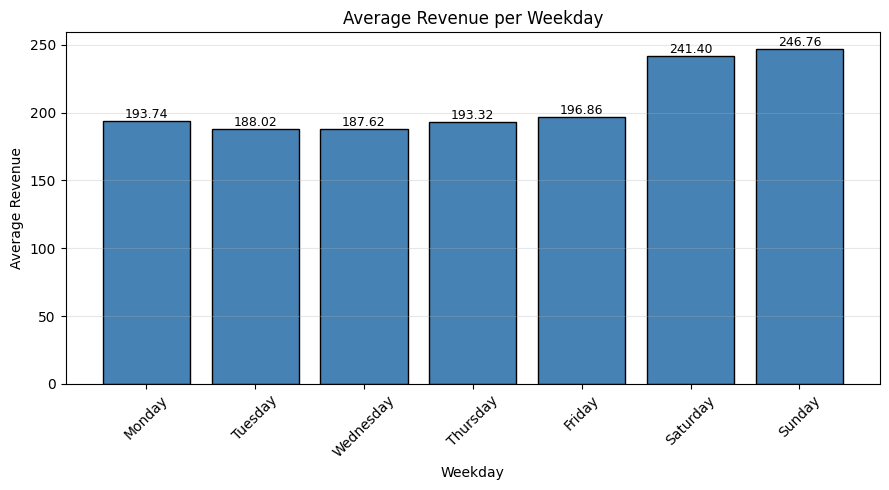

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# determine column names robustly
if 'merged_cleaned' not in globals():
    raise KeyError("DataFrame 'merged_cleaned' not found in the notebook namespace.")

revenue_col = 'Revenue' if 'Revenue' in merged_cleaned.columns else ('Umsatz' if 'Umsatz' in merged_cleaned.columns else None)
date_col = 'Date' if 'Date' in merged_cleaned.columns else ('Datum' if 'Datum' in merged_cleaned.columns else None)

if revenue_col is None:
    raise KeyError("Keine Spalte 'Umsatz' oder 'Revenue' in merged_cleaned gefunden.")
if date_col is None:
    raise KeyError("Keine Spalte 'Datum' oder 'Date' in merged_cleaned gefunden.")

# ensure date column is datetime
merged_cleaned[date_col] = pd.to_datetime(merged_cleaned[date_col])

# prepare aggregated data: average revenue per weekday (Mon-Sun)
df = merged_cleaned[[date_col, revenue_col]].copy()
df['weekday_num'] = df[date_col].dt.weekday  # Monday=0
df['weekday'] = df[date_col].dt.day_name()

avg_by_weekday = df.groupby(['weekday_num', 'weekday'])[revenue_col].mean().reset_index()
avg_by_weekday = avg_by_weekday.sort_values('weekday_num')

# show table
print(avg_by_weekday[['weekday', revenue_col]].to_string(index=False))

# plot
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(avg_by_weekday['weekday'], avg_by_weekday[revenue_col], color='steelblue', edgecolor='black')
ax.set_xlabel('Weekday')
ax.set_ylabel(f'Average {revenue_col}')
ax.set_title('Average Revenue per Weekday')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# annotate values above bars
for bar, val in zip(bars, avg_by_weekday[revenue_col]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Average Umsatz per Warengruppe:
product_name     Umsatz
     1=Bread 122.142509
     2=Roles 402.497911
 3=Croissant 163.340920
    4=Pastry  87.954042
     5=Cakes 276.795509
  6=Seasonal  66.916635


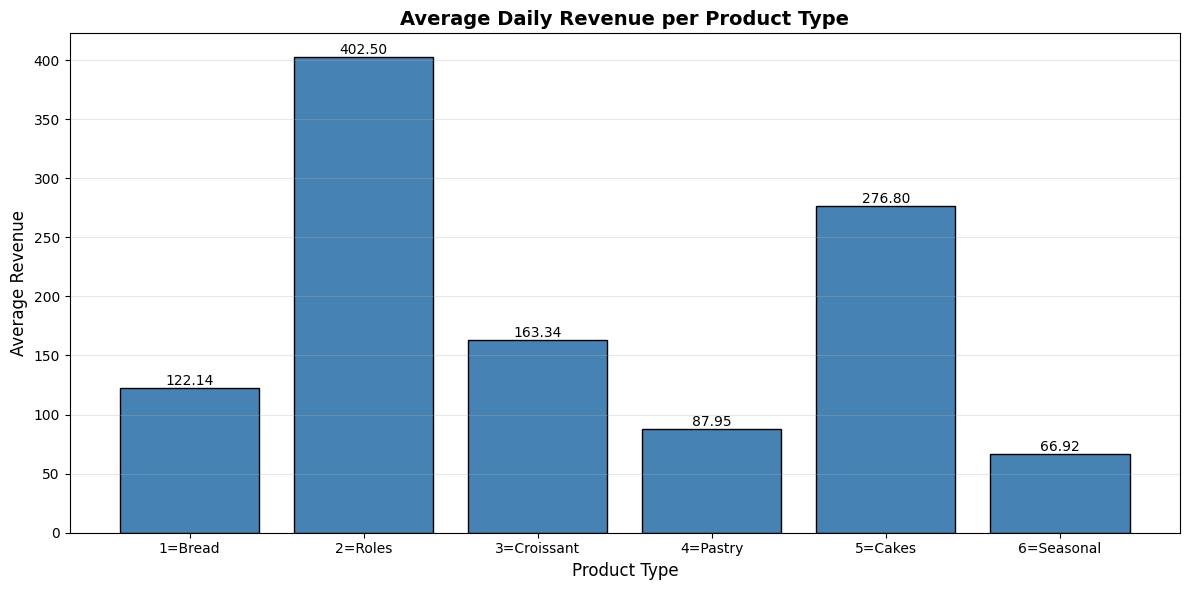

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# determine product column name
product_col = 'Warengruppe' if 'Warengruppe' in sales.columns else None
revenue_col = 'Umsatz' if 'Umsatz' in sales.columns else None

if product_col is None or revenue_col is None:
    raise KeyError("Spalten 'Warengruppe' oder 'Umsatz' nicht in sales DataFrame gefunden.")

# calculate average revenue per product type
avg_by_product = sales.groupby(product_col)[revenue_col].mean().reset_index()
avg_by_product = avg_by_product.sort_values(product_col)  # Sort by product type (1-6)

# create mapping for product names
product_mapping = {
    1: "1=Bread",
    2: "2=Roles",
    3: "3=Croissant",
    4: "4=Pastry",
    5: "5=Cakes",
    6: "6=Seasonal"
}

# map product codes to names
avg_by_product['product_name'] = avg_by_product[product_col].map(product_mapping)

# display table
print(f"Average {revenue_col} per {product_col}:")
print("=" * 50)
print(avg_by_product[['product_name', revenue_col]].to_string(index=False))

# create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(avg_by_product['product_name'], avg_by_product[revenue_col], color='steelblue', edgecolor='black')
ax.set_xlabel('Product Type', fontsize=12)
ax.set_ylabel('Average Revenue', fontsize=12)
ax.set_title(f'Average Daily Revenue per Product Type', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0, ha='center')

# annotate values above bars
for bar, val in zip(bars, avg_by_product[revenue_col]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.2f}", 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

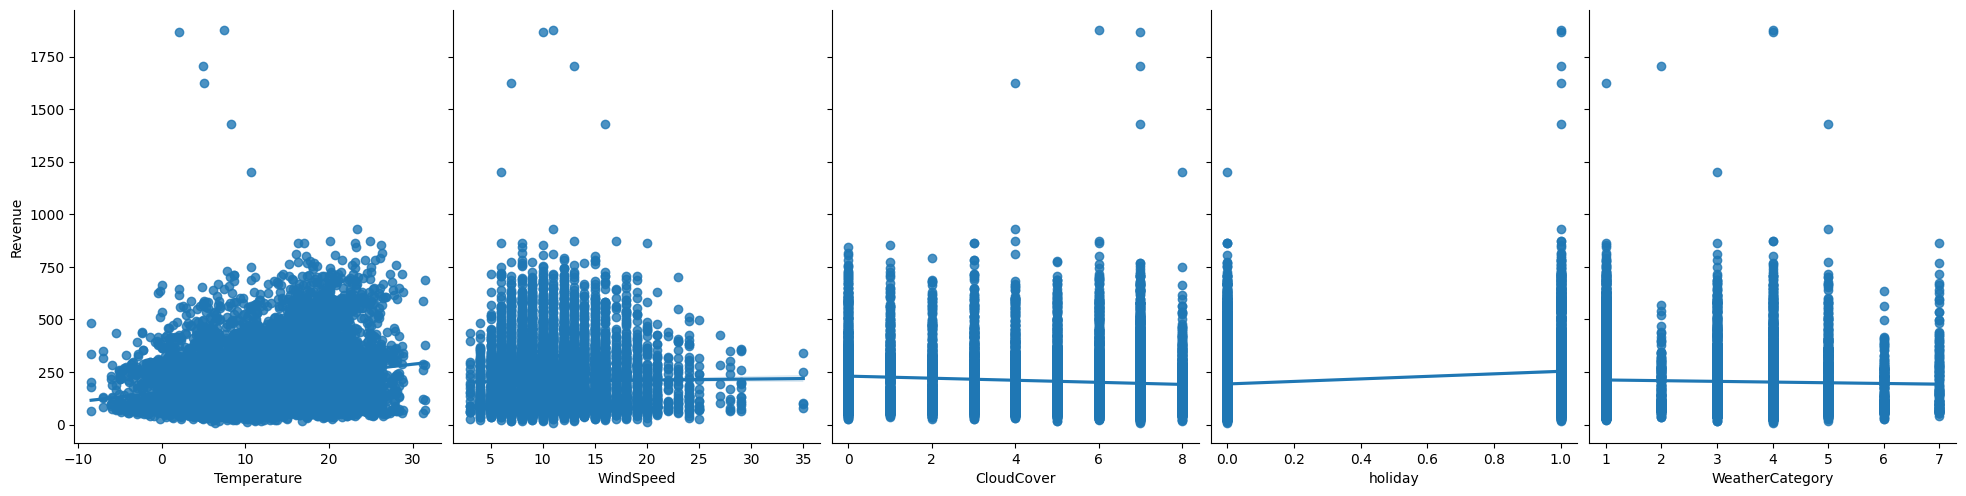

In [20]:

import seaborn as sns

sns.pairplot(merged_cleaned, 
             x_vars=['Temperature', 'WindSpeed', 'CloudCover', 'holiday', 'WeatherCategory'], 
             y_vars='Revenue', 
             height=5, 
             aspect=0.8, 
             kind='reg')

plt.show()

In [21]:
# ...existing code...
# new cell: inspect WeatherCode values and counts
df = merged_cleaned if 'merged_cleaned' in globals() else (merged if 'merged' in globals() else None)
if df is None:
    raise KeyError("Neither 'merged_cleaned' nor 'merged' found in the notebook namespace.")

# find weather-code column
candidates = [c for c in df.columns if c.lower() in ('weathercode', 'wettercode')]
if not candidates:
    raise KeyError("WeatherCode column not found. Available columns: " + ", ".join(df.columns))

col = candidates[0]
print(f"Using column: {col}  (dtype: {df[col].dtype})\n")

vc = df[col].value_counts(dropna=False).sort_index()
print("Value counts (including NaN):")
print(vc.to_string())

print("\nNumber of unique values (including NaN):", df[col].nunique(dropna=False))
# ...existing code...

Using column: WeatherCode  (dtype: float64)

Value counts (including NaN):
WeatherCode
0.0      815
3.0        5
5.0      562
10.0     742
17.0       5
20.0     244
21.0    1013
22.0      88
28.0      63
45.0      96
49.0      48
53.0      31
61.0    2271
63.0     535
65.0     111
68.0      12
69.0      27
71.0      81
73.0      48
75.0      25
77.0      45
79.0       5
95.0     137
NaN     2313

Number of unique values (including NaN): 24


<Axes: xlabel='WeatherCategory', ylabel='Revenue'>

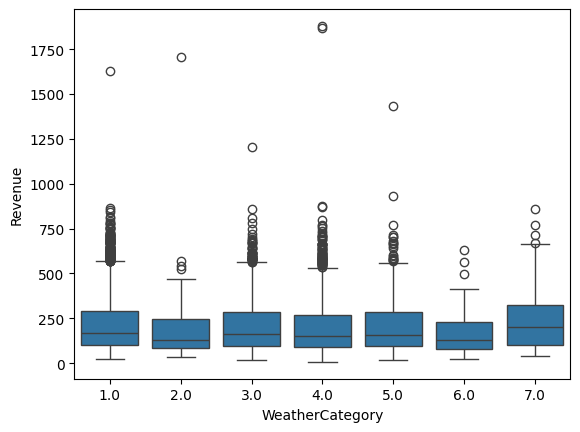

In [22]:
import seaborn as sns
sns.boxplot(data=merged_cleaned, x="WeatherCategory", y="Revenue")

# 1 Clear, sunny, dry
# 2 Fog
# 3 Rain stopped
# 4 Light rain
# 5 Moderate to strong rain
# 6 Snow
# 7 Thunderstorm

In [23]:
df = merged_cleaned


In [24]:
# Split dataset into train/validation/test by date ranges (inclusive)

# use merged_cleaned if available, otherwise fall back to merged
df = merged_cleaned if 'merged_cleaned' in globals() else (merged if 'merged' in globals() else None)
if df is None:
    raise KeyError("Neither 'merged_cleaned' nor 'merged' found in notebook namespace.")

# robust date column lookup
date_col = 'Date' if 'Date' in df.columns else ('Datum' if 'Datum' in df.columns else None)
if date_col is None:
    raise KeyError("No date column found ('Date' or 'Datum').")

# ensure datetime
df[date_col] = pd.to_datetime(df[date_col])

# define inclusive ranges
train_start = pd.Timestamp('2013-07-01')
train_end   = pd.Timestamp('2017-07-31')
val_start   = pd.Timestamp('2017-08-01')
val_end     = pd.Timestamp('2018-07-31')
test_start  = pd.Timestamp('2018-08-01')
test_end    = pd.Timestamp('2019-07-31')

# filter
train_df = df[(df[date_col] >= train_start) & (df[date_col] <= train_end)].copy()
val_df   = df[(df[date_col] >= val_start)   & (df[date_col] <= val_end)].copy()
test_df  = df[(df[date_col] >= test_start)  & (df[date_col] <= test_end)].copy()

# quick sanity prints
def summary(name, d):
    if d.empty:
        print(f"{name}: EMPTY")
    else:
        print(f"{name}: rows={d.shape[0]}, dates={d[date_col].min().date()} - {d[date_col].max().date()}")

summary('Train', train_df)
summary('Validation', val_df)
summary('Test', test_df)

# Optional: persist to CSV if needed
# train_df.to_csv('/workspaces/TeamCPH/train_20130701_20170731.csv', index=False)
# val_df.to_csv('/workspaces/TeamCPH/val_20170801_20180731.csv', index=False)
# test_df.to_csv('/workspaces/TeamCPH/test_20180801_20190731.csv', index=False)

Train: rows=7492, dates=2013-07-01 - 2017-07-31
Validation: rows=1830, dates=2017-08-01 - 2018-07-31
Test: EMPTY


In [25]:
# multilinear regression model
predictors = [
    "holiday",
    "IsWeekend",
    "IsNewYears",
    "Easter",
    "sin_1y", 
    "cos_1y", 
    "sin_2y", 
    "cos_2y",
    "Revenue_lag1", 
    "Revenue_lag7"
]

model_df = train_df[["Revenue"] + predictors].dropna()

Y = model_df ["Revenue"]
X = sm.add_constant(model_df[predictors])

model = sm.OLS(Y,X)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     3476.
Date:                Thu, 18 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:24:57   Log-Likelihood:                -41312.
No. Observations:                7450   AIC:                         8.265e+04
Df Residuals:                    7439   BIC:                         8.272e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.7599      1.401      6.254   

In [26]:
# predict Revenue

m1 = results.params["Temperature"]
m2 = results.params["KielWeek"]
m3 = results.params["holiday"]
b = results.params["const"]

Temperature = 20
KielWeek = 1
Holiday = 0

Revenue = m1 * Temperature + m2 * KielWeek + m3 * Holiday + b
print(f"Predicted Revenue for {Temperature}°C: {Revenue:.2f}")

KeyError: 'Temperature'

In [ ]:
merged_cleaned["IsHalloween"].value_counts()

IsHalloween
0    2117
1      45
Name: count, dtype: int64

In [ ]:
bad = train_df[predictors].replace([np.inf, -np.inf], np.nan).isna().sum()
print(bad[bad > 0].sort_values(ascending=False))

Revenue_lag7    7
Revenue_lag1    1
dtype: int64
